# Visualizing Conv filters using ActivationMaximization

## Preparation

### Install libraries

At first, when you didn't yet installed `tf-keras-vis` in your environment such Google Colab, please run the cell below.

In [ ]:
!pip install --upgrade tf-keras-vis tensorflow matplotllib

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

Define modifier to replace the model output to target layer's output that has filters you want to visualize.

In [4]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

### Create ActivationMaximization Instnace

If `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it takes a machine resources.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Loss function

You MUST define Loss function that return arbitrary filter values. Here, it returns the value corresponding third filter in `block5_conv3` layer. ActivationMaximization will maximize the filter value.

In [6]:
filter_number = 3
def loss(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the loss function. Here, we try to visualize a convolutional filter.

Steps: 050	Losses: [[350.7877502441406]],	Regularizations: [('TotalVariation', 109.0577621459961), ('L2Norm', 0.02551686204969883)]
Steps: 100	Losses: [[580.2254028320312]],	Regularizations: [('TotalVariation', 128.7722625732422), ('L2Norm', 0.02530454471707344)]
Steps: 150	Losses: [[666.67041015625]],	Regularizations: [('TotalVariation', 133.77325439453125), ('L2Norm', 0.025157012045383453)]
Steps: 200	Losses: [[686.7802124023438]],	Regularizations: [('TotalVariation', 137.57752990722656), ('L2Norm', 0.025064880028367043)]


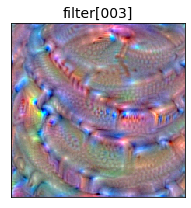

CPU times: user 13min 2s, sys: 1min 56s, total: 14min 58s
Wall time: 5min 28s


In [7]:
%%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Loss function

When visualizing multiple convolutional filters, you MUST define Loss function that return arbitrary filter values for each layer.

In [8]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

### Create SeedInput values

And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

Here, we will visualize 3 images while `steps` option is to be 512 to get clear images.

Steps: 050	Losses: [[549.0399169921875, 345.06689453125, 466.9295959472656]],	Regularizations: [('TotalVariation', 44.07203674316406), ('L2Norm', 0.01469449046999216)]
Steps: 100	Losses: [[737.2769165039062, 537.2666015625, 813.287841796875]],	Regularizations: [('TotalVariation', 51.623985290527344), ('L2Norm', 0.014554964378476143)]
Steps: 150	Losses: [[890.2518920898438, 568.4459228515625, 824.548095703125]],	Regularizations: [('TotalVariation', 51.60739517211914), ('L2Norm', 0.014453783631324768)]
Steps: 200	Losses: [[968.8577270507812, 640.1527099609375, 947.8431396484375]],	Regularizations: [('TotalVariation', 54.06696701049805), ('L2Norm', 0.014364605769515038)]
Steps: 250	Losses: [[986.3164672851562, 733.1770629882812, 984.0664672851562]],	Regularizations: [('TotalVariation', 57.14896774291992), ('L2Norm', 0.014271333813667297)]
Steps: 300	Losses: [[915.11865234375, 625.8380126953125, 962.956787109375]],	Regularizations: [('TotalVariation', 55.33357620239258), ('L2Norm', 0.01425

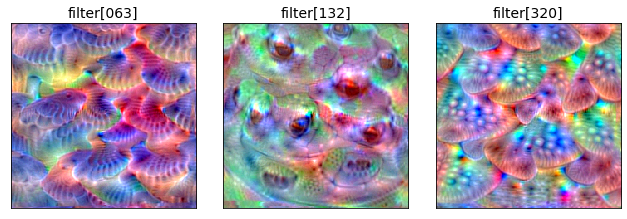

CPU times: user 1h 35min 24s, sys: 9min 11s, total: 1h 44min 35s
Wall time: 39min 43s


In [10]:
%%time

# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()